# 1D Fast Accurate Fourier Transform

In [5]:
import numpy as np
import ctypes
from ctypes import *

import pycuda.gpuarray as gpuarray
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math


In [6]:
%matplotlib inline    


## Loading FFT routines

In [7]:
gridDIM = 64

size = gridDIM

axes0 = 0

m = size

DIR_BASE = "/home/robert/Documents/new1/FFT/code/"

# FAFT 
_faft128_1D = ctypes.cdll.LoadLibrary( DIR_BASE+'FAFT128_1D_R2C.so' )
_faft128_1D.FAFT128_1D_R2C.restype = int
_faft128_1D.FAFT128_1D_R2C.argtypes = [ctypes.c_void_p, ctypes.c_void_p,
                                                 ctypes.c_float, ctypes.c_float, ctypes.c_int]

cuda_faft = _faft128_1D.FAFT128_1D_R2C

# IFAFT
_ifaft128_1D = ctypes.cdll.LoadLibrary( DIR_BASE+'IFAFT128_1D_C2R.so' )
_ifaft128_1D.IFAFT128_1D_C2R.restype = int
_ifaft128_1D.IFAFT128_1D_C2R.argtypes = [ctypes.c_void_p, ctypes.c_void_p, 
                                                 ctypes.c_float, ctypes.c_float, ctypes.c_int]

cuda_ifaft = _ifaft128_1D.IFAFT128_1D_C2R

In [8]:
def fftGaussian(p,sigma):
    return np.exp( - p**2*sigma**2/2.  )

## Initializing a Gaussian

 Amplitude x =  7.0
 Amplitude p =  5.0
        
sigma =  1.0
n     =  64
dx    =  0.21875
dp    =  0.15625
           standard fft dp =  0.448798950513      
    
delta =  0.00543986621896
    
The Gaussian extends to the numerical error in single precision:
  extremes  8.16623563167e-17  ,  3.5020774043e-07


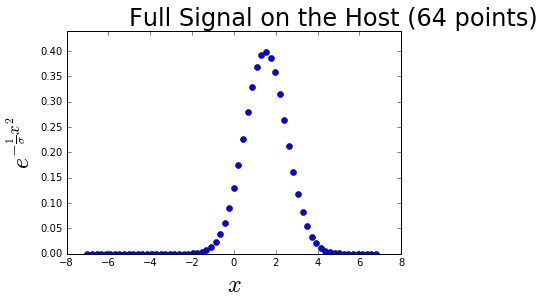

In [9]:
# Gaussian parameters
mu = 1.5
sigma = 1.

# Grid parameters
x_amplitude = 7.
p_amplitude = 5.                # With the traditional method p amplitude is fixed to: 2 * np.pi /( 2*x_amplitude ) 

dx = 2*x_amplitude/float(size)  # This is beta in Bailey's paper
dp = 2*p_amplitude/float(size)  # This is gamma in Bailey's paper

delta = dx*dp/(2*np.pi)

x = np.linspace( -x_amplitude, x_amplitude-dx, size)  
p = np.linspace( -p_amplitude, p_amplitude-dx, size) 

f = mlab.normpdf(x, mu, sigma)

plt.plot(x, f,'o')

axis_font = {'size':'24'}
plt.text( -5, .45, 'Full Signal on the Host (64 points)' , **axis_font)
plt.ylabel('$e^{-\\frac{1}{\\sigma }x^2}$',**axis_font)
plt.xlabel('$x$',**axis_font)

plt.ylim(0,0.44)

print ' Amplitude x = ',x_amplitude
print ' Amplitude p = ',p_amplitude
print '        '

print 'sigma = ', sigma
print 'n     = ', x.size
print 'dx    = ', dx
print 'dp    = ', dp
print '           standard fft dp = ',2 * np.pi /( 2*x_amplitude ) , '     '
print '    '
print 'delta = ', delta


print '    '

print 'The Gaussian extends to the numerical error in single precision:'  
print '  extremes ', f[0], ' , ', f[-1]


In [10]:
f65 = np.zeros( [ 1 ], dtype = np.complex64 )

In [11]:
# Copy data to GPU

segment = 0

f_gpu = gpuarray.to_gpu( np.ascontiguousarray( f , dtype = np.float32 ) )
f65_gpu = gpuarray.to_gpu( np.ascontiguousarray( f65 , dtype = np.complex64 ) )


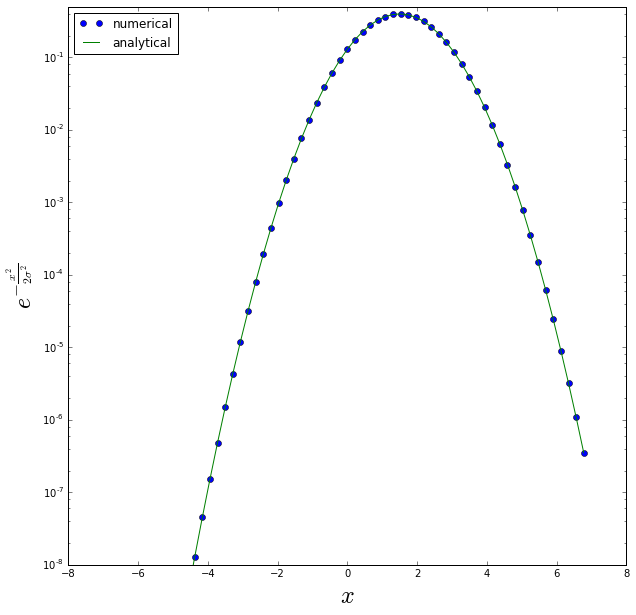

In [12]:
# LOG PLOT 

plt.figure(figsize=(10,10))

plt.semilogy( x, f_gpu.get()  , 'o', label='numerical')

plt.semilogy( x, mlab.normpdf(x, mu, sigma) , label = 'analytical')

plt.legend(loc='upper left')

plt.ylim(1e-8,0.5)

plt.ylabel('$e^{- \\frac{x^2}{2 \\sigma^2 } }$',**axis_font)
plt.xlabel('$x$',**axis_font)

### Forward Transform

In [13]:
# Executing FFT

cuda_faft( int(f_gpu.gpudata), int(f65_gpu.gpudata), dx, delta, segment )

1

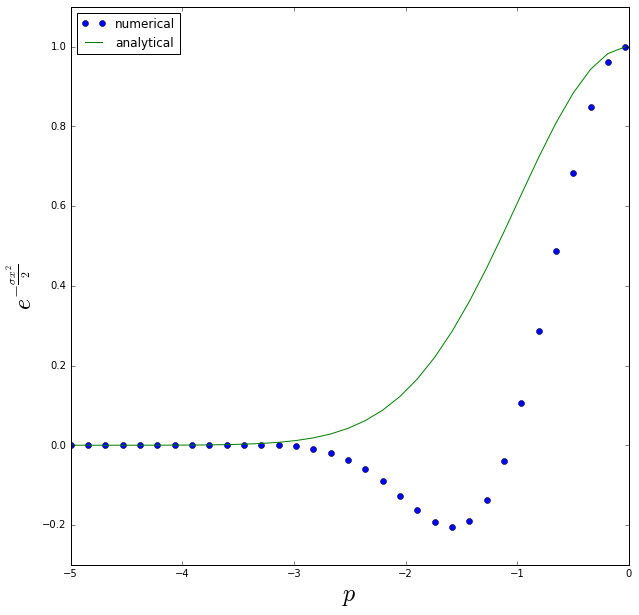

In [14]:
plt.figure(figsize=(10,10))

plt.plot( p[:33], np.append( f_gpu.get()[:32], f65_gpu.get().real )/(2*f_gpu.get().size) , 'o', label='numerical')

plt.plot( p[:33], fftGaussian(p,sigma)[:33] , label = 'analytical')

plt.legend(loc='upper left')

plt.ylim(-0.3,1.1)

plt.ylabel('$e^{- \\frac{\\sigma x^2}{2} }$',**axis_font)
plt.xlabel('$p$',**axis_font)

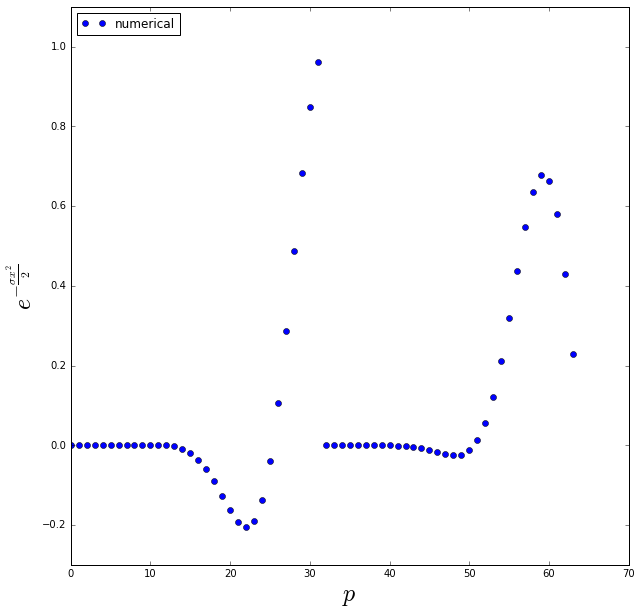

In [15]:
plt.figure(figsize=(10,10))

plt.plot(  f_gpu.get()/(2*f_gpu.get().size) , 'o', label='numerical')

plt.legend(loc='upper left')

plt.ylim(-0.3 , 1.1)

plt.ylabel('$e^{- \\frac{\\sigma x^2}{2} }$',**axis_font)
plt.xlabel('$p$',**axis_font)

In [16]:
def ReconstructFFT(f):
    n = f.shape[0]
    
    freal_half = f_gpu.get()[:n/2]
    freal      = np.append( freal_half ,  f65_gpu.get().real )
    freal      = np.append( freal      ,  freal_half[:0:-1]  )
    
    fimag_half = f_gpu.get()[n/2:]
    fimag      = np.append( fimag_half ,   np.array([0.])    )
    fimag      = np.append( fimag      ,  -fimag_half[:0:-1]  )
        
    return freal + 1j*fimag

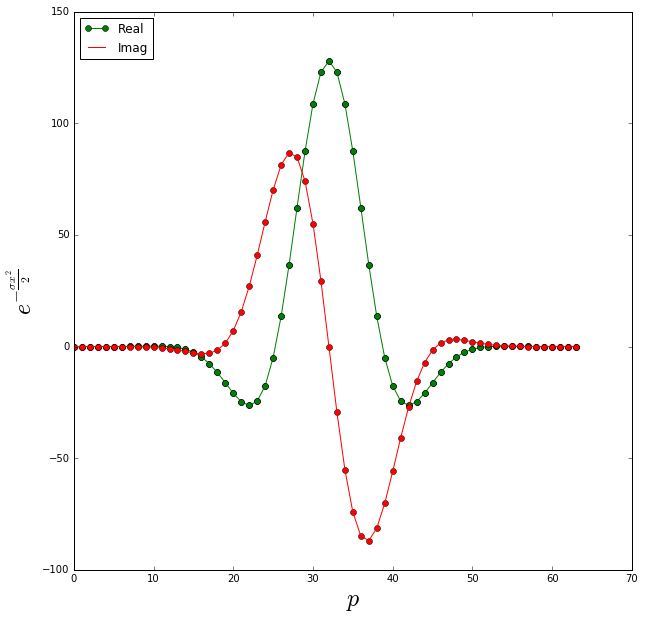

In [17]:
plt.figure(figsize=(10,10))

plt.plot(  ReconstructFFT( f_gpu.get() ).real  ,  'o'  )
plt.plot(  ReconstructFFT( f_gpu.get() ).real  ,  'o-' , label='Real')
plt.plot(  ReconstructFFT( f_gpu.get() ).imag  ,  'ro' )
plt.plot(  ReconstructFFT( f_gpu.get() ).imag  ,  'r-' ,label='Imag')

plt.ylabel('$e^{- \\frac{\\sigma x^2}{2} }$',**axis_font)
plt.xlabel('$p$',**axis_font)

plt.legend(loc='upper left')

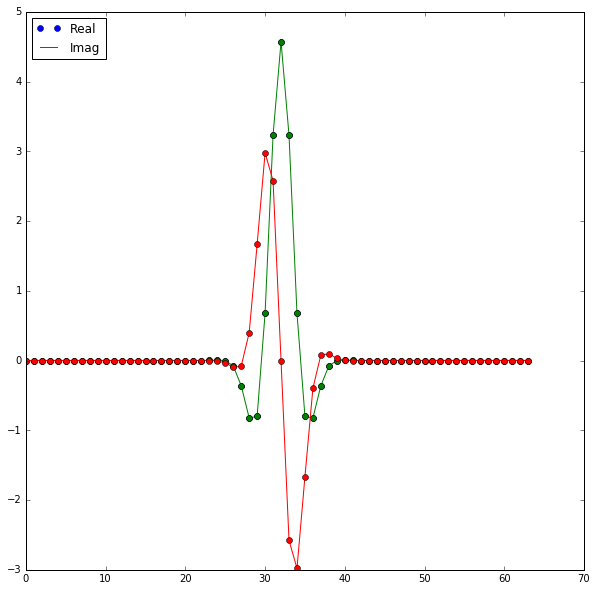

In [18]:
# Standard fft :
# Onserve how much memory is lost in zeros 

plt.figure(figsize=(10,10))
plt.plot( np.fft.fftshift( np.fft.fft( np.fft.fftshift(f)  ) ).real  ,'o',  label='Real')
plt.plot( np.fft.fftshift( np.fft.fft( np.fft.fftshift(f)  ) ).real  ,'o-'  )
plt.plot( np.fft.fftshift( np.fft.fft( np.fft.fftshift(f)  ) ).imag  ,'r-', label='Imag')
plt.plot( np.fft.fftshift( np.fft.fft( np.fft.fftshift(f)  ) ).imag  ,'ro')

plt.legend(loc='upper left')


### Inverse

In [19]:
# For Inverse Transform, enter "-delta"

cuda_ifaft( int(f_gpu.gpudata), int(f65_gpu.gpudata), dx, -delta, segment )

1

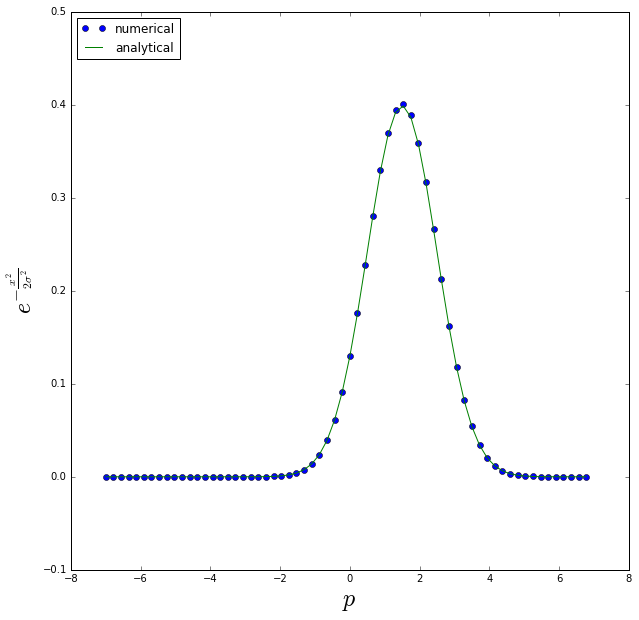

In [20]:
plt.figure(figsize=(10,10))

plt.plot( x, f_gpu.get()/ (2*f_gpu.get().size)/(17.5*f_gpu.get().size), 'o', label='numerical')

plt.plot( x, mlab.normpdf(x, mu, sigma) , label = 'analytical')

plt.legend(loc='upper left')

#plt.ylim(0,0.5)

plt.ylabel('$e^{- \\frac{x^2}{2 \\sigma^2 } }$',**axis_font)
plt.xlabel('$p$',**axis_font)

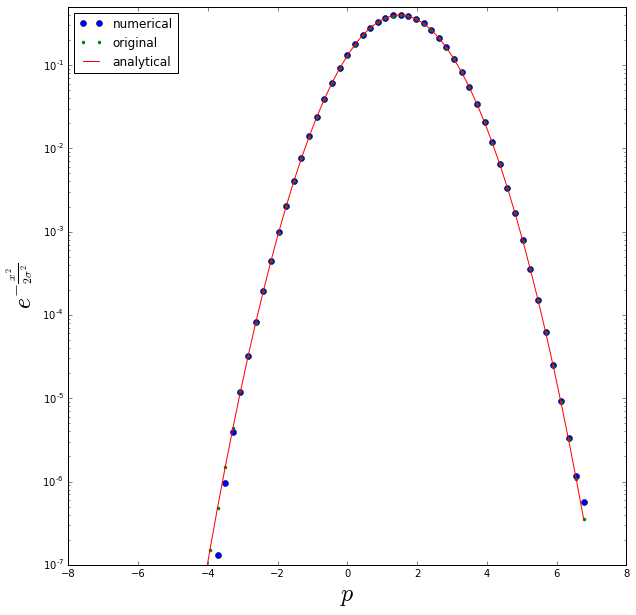

In [21]:
# LOG PLOT 

plt.figure(figsize=(10,10))

plt.semilogy( x, f_gpu.get()/ (2*f_gpu.get().size)/(17.5*f_gpu.get().size)  , 'o', label='numerical')

plt.semilogy( x, f  , '.', label='original')

plt.semilogy( x, mlab.normpdf(x, mu, sigma) , label = 'analytical')

plt.legend(loc='upper left')

plt.ylim(1e-7,0.5)

plt.ylabel('$e^{- \\frac{x^2}{2 \\sigma^2 } }$',**axis_font)
plt.xlabel('$p$',**axis_font)